X shape : torch.Size([2500, 2])
y shape : torch.Size([2500, 1])


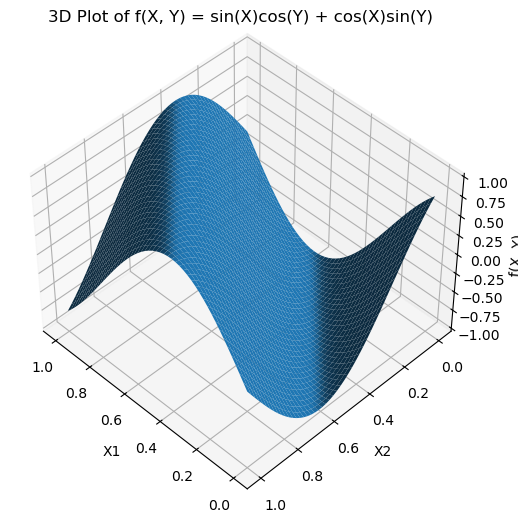

In [1]:
import sys
import os

# Add the path to the parent module
sys.path.append(os.path.abspath('../..'))

import warnings
warnings.filterwarnings('ignore')


import deeppy as dp

import torch
import torch.optim as optim
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

from assets.tutorial_utils import *

from deeppy import LearnFrame
from deeppy import data
from deeppy.data import DataGetter
from deeppy.models import LayerGenerator, Optimizer, Scheduler
from deeppy.models import Network
from deeppy.models import Model


X,y = get_toy_data_and_plot()

DataGetter_params = {
    "X" : X,
    "y": y,
    "X_valid":None,
    "test_size":0.,
    "test_batch_size":None,
    "valid_batch_size":None,
    "batch_size":128,
    "num_workers":0,
    "pin_memory":True,
    "shuffle":True,
}

data = dp.data.DataGetter(**DataGetter_params)
Xd,yd = data.train_data()



In [3]:


Scheduler_params = {
    "scheduler" : optim.lr_scheduler.StepLR,
    "gamma":(1e-5 / 5e-4)**(1/10000),
    "auto_step":True,
    "step_size" : 1
}

Scheduler_params = {
    "scheduler" : optim.lr_scheduler.CyclicLR,
    "max_lr":5e-4,
    "base_lr":1e-5,
    "step_size_up":2000,
    "auto_step":True,
    "mode":"triangular2"
}

Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr":1e-4, "amsgrad" : True, "weight_decay" : 1e-3},
    "clipper":torch.nn.utils.clip_grad_value_,
    "clipper_params":{"clip_value" : 100},
    "scheduler_params":Scheduler_params,
}

arch_param_1 = {
    "blocks":[nn.GRU],
    "block_args": [{"input_size" : 8, "hidden_size" : 4, "num_layers" : 2}],
    "out_act":nn.Identity,
    "out_params":{},
    "weight_init":"uniform",
}

arch_param_2 = {
    "layers":[4,1],
    "blocks":[nn.Linear, nn.ReLU],
    "block_args":[],
    "out_act":nn.Identity,
    "out_params":{},
    "weight_init":"uniform",
}

Network_params = {
"arch_params":[arch_param_1,arch_param_2],
"decoder_params":None,
"task":'reg',
"optimizer_params":Optimizer_params,
}

Model_params = {
    "network_params":Network_params,
    "device":device,
    "criterion":nn.MSELoss(),
}

model = Model(**Model_params)



In [4]:
arch_param_1["blocks"][0].__name__

'GRU'

In [13]:
model(torch.rand(128,8, device=device))[0]

tensor([0.0698], device='cuda:0', grad_fn=<SelectBackward0>)

In [16]:

def n_forward(self,X):
    X1 = X[:,0].view(-1,1)
    X2 = X[:,1]
    print(X1.shape)
    o1 = self.partial_forward(X1,0)
    print(o1.shape)
    i2 = torch.stack((o1,X2), dim=1)
    return self.partial_forward(i2,1)


import types
model.net.forward  = types.MethodType(n_forward, model.net)


In [17]:
lf = dp.LearnFrame(model, data)

In [18]:
def get_norm(lf):
    total_norm = 0
    for p in lf.model.nets[0].model.parameters():
        param_norm = p.grad.detach().data.norm(2)
        total_norm += param_norm.item() ** 2
    return total_norm ** 0.5
def get_layer_norm(lf):
    total_norms = []
    for p in lf.model.nets[0].model.parameters():
        param_norm = p.grad.detach().data.norm(2)
        total_norms.append(param_norm.item())
    return total_norms
total_norms = []




In [19]:
lf.metric.plot_lr = True
for i in range(200):
    lf.optimize()
    total_norms.append(get_layer_norm(lf))
lf.plot(show_result=True, log=True)

torch.Size([128, 1])
torch.Size([128, 32])


RuntimeError: stack expects each tensor to be equal size, but got [128, 32] at entry 0 and [128] at entry 1

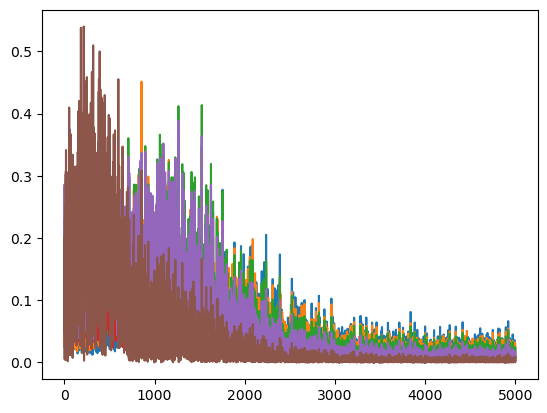

In [6]:
plt.plot(np.asarray(total_norms))

In [33]:
#ReLU - Step 0.01 - 10000

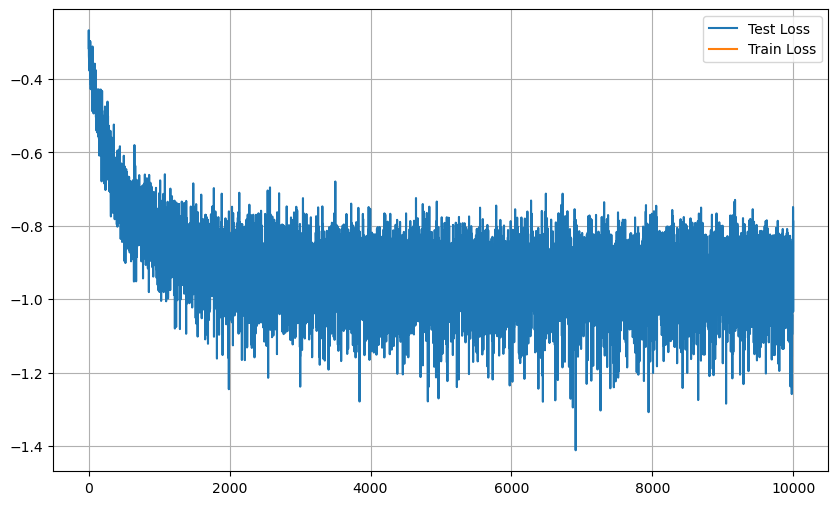

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [34]:
for i in range(10000):
    lf.optimize()
lf.plot(show_result=True, log=True)